# CNN's with the Cats vs Dogs Dataset

`Cats vs Dogs` 데이터 셋을 이용해서 개/고양이 구분하는 문제를 풀어보겠습니다.  
Convolutional Neural Network 를 사용합니다.    

In [2]:
# 필요한 라이브러리들을 import  합니다.

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

데이터 셋을 다운 받습니다.


https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip 에서 파일을 다운 받도록 하겠습니다.  
787MB 의 용량이니 다소 시간이 걸릴 수 있습니다.  

압축을 풀고 파일 경로를 맞춰줍니다. `./data/PetImages` 에 데이터를 위치하시면 아래 코드와 맞습니다.

In [2]:
source_path = './data/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# .db 파일들이 섞여 있기 때문에 지워 줍니다.
import glob, os
for f in glob.glob("./data/PetImages/*/*.db"):
    os.remove(f)

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


**예상 결과:**

```
There are 12500 images of dogs.
There are 12500 images of cats.
```

Trainig 과 Validation 을 위해 데이터를 나눠 줍니다.

In [3]:
root_dir = './data/cats-v-dogs'

# 초기화 합니다.
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

In [4]:
def create_train_val_dirs(root_path):
  # 디렉토리를 준비합니다.

  os.mkdir(root_path)
  train_dir = os.path.join(root_path, 'training')
  os.mkdir(train_dir)
  validation_dir = os.path.join(root_path, 'validation')
  os.mkdir(validation_dir)

  # 학습용 디렉토리
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')

  # 검증용 디렉토리
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')

  os.mkdir(train_cats_dir)
  os.mkdir(train_dogs_dir)
  os.mkdir(validation_cats_dir)
  os.mkdir(validation_dogs_dir)

  pass

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("이미 존재함!")

In [5]:
# Test your create_train_val_dirs function
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./data/cats-v-dogs\training
./data/cats-v-dogs\validation
./data/cats-v-dogs\training\cats
./data/cats-v-dogs\training\dogs
./data/cats-v-dogs\validation\cats
./data/cats-v-dogs\validation\dogs


**예상 결과, 순서는 다를 수 있음:**

``` txt
./data/cats-v-dogs/training
./data/cats-v-dogs/validation
./data/cats-v-dogs/training/cats
./data/cats-v-dogs/training/dogs
./data/cats-v-dogs/validation/cats
./data/cats-v-dogs/validation/dogs

```

 `split_data` 함수를 만들어 봅시다
- SOURCE_DIR: 데이터 소스 경로

- TRAINING_DIR: 학습 데이터 경로
- VALIDATION_DIR: 검증 데이터 경로
- SPLIT_SIZE: 나눌 데이터 사이즈

이미지 파일들은 랜덤하게 나워져야만 합니다.

예를 들어, `SOURCE_DIR` 이고 `PetImages/Cat`,  `SPLIT_SIZE` 가 .9 라면, 
`PetImages/Cat`에 있는 90% 의 이미지는 `TRAINING_DIR` 로 복사되어야 합니다.  
나머지 10% 의 이미지는 `VALIDATION_DIR` 로 복사되어야 합니다.  

모든 이미지는 복사되기 전에 빈 파일이 아닌지 체크해야합니다.  

(참고)

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [6]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  files = [os.path.join(SOURCE_DIR, f) for f in os.listdir(SOURCE_DIR) if os.path.isfile(os.path.join(SOURCE_DIR, f))]
  random.shuffle(files)

  files = [file for file in files if os.path.getsize(file) != 0]

  train_len = int(len(files)*SPLIT_SIZE)

  train_files = files[:train_len]
  validation_files = files[train_len:]

  for file_path in train_files:
      copyfile(file_path, os.path.join(TRAINING_DIR, os.path.basename(file_path))  )
  for file_path in validation_files:
      copyfile(file_path, os.path.join(VALIDATION_DIR, os.path.basename(file_path)))

  pass


In [7]:
CAT_SOURCE_DIR = "./data/PetImages/Cat/"
DOG_SOURCE_DIR = "./data/PetImages/Dog/"

TRAINING_DIR = "./data/cats-v-dogs/training/"
VALIDATION_DIR = "./data/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")


if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)


split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


**예상 결과:**

```
Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

이제,  Keras의 `ImageDataGenerator` 를 사용할 준비가 되었습니다.  
학습과 검증을 위한 이미지의 batch 를 만들어 봅시다.
  

중요한 점 중 하나는 이미지의 해상도가 각기 다르다는 점입니다.  
다행히 `flow_from_directory` method 는 이미지를 같은 해상도로 만들어 줍니다.  
`target_size` 사용하여 해상도를 맞춥니다.  


**`target_size` 는 (150, 150) 으로 설정합니다**.


In [43]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # rescale 을 이용해서 normalize 를 해줍니다. 0~1 범위로 설정합니다
  train_datagen = ImageDataGenerator( rescale = 1.0/255. )

  # data를 준비합니다.
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [44]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**예상 결과:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


모델의 정의합니다.

Keras' `Sequential` model을 사용합니다

`loss` 도 `class_mode` 에 맞게 설정합니다.

**최소한 3개의 convolution layer 가 있어야 개/고양이를 잘 구분할 수 있습니다.**

In [10]:
def create_model():

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

  return model

학습 시작!

**Note:** `UserWarning: Possibly corrupt EXIF data` 워닝은 무시하셔도 됩니다

In [11]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.7009

C:\Users\jhpark\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 513s 455ms/step - loss: 0.5815 - accuracy: 0.7009 - val_loss: 0.5290 - val_accuracy: 0.7320
Epoch 2/15
1125/1125 [==============================] - 384s 341ms/step - loss: 0.4421 - accuracy: 0.7920 - val_loss: 0.5187 - val_accuracy: 0.7504
Epoch 3/15
1125/1125 [==============================] - 401s 357ms/step - loss: 0.3303 - accuracy: 0.8555 - val_loss: 0.5262 - val_accuracy: 0.7604
Epoch 4/15
1125/1125 [==============================] - 377s 335ms/step - loss: 0.1874 - accuracy: 0.9247 - val_loss: 0.6109 - val_accuracy: 0.7728
Epoch 5/15
1125/1125 [==============================] - 383s 340ms/step - loss: 0.0756 - accuracy: 0.9752 - val_loss: 0.8110 - val_accuracy: 0.7660
Epoch 6/15
1125/1125 [==============================] - 387s 344ms/step - loss: 0.0409 - accuracy: 0.9883 - val_loss: 1.0217 - val_accuracy: 0.7716
Epoch 7/15
1125/1125 [==============================] - 403s 358ms/step - loss: 0.0321 - accuracy: 0.9913 - val_loss: 1.222

KeyboardInterrupt: 

학습이 완료되면 아래 코드를 이용해서 얼마나 잘 구분을 하는지 확인 할 수 있습니다..

**Training accuracy 는 적어도 95%, validation accuracy 는 적어도 80%** 가 나와야 충분합니다.  
다양한 옵션들을 사용하면 성능을 더 끌어올릴 수 있습니다.

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# Overfitting 해결하기
- Overfitting 에 대해 생각해 봅시다... ㅠㅠ

Overfitting 은 여러가지 방법으로 해결할 수 있습니다.  
범용적으로 가장 쉬운 해결책은 목표 성능에 도달하면 학습을 멈추는 것입니다.  
Early Stopping 을 구현해봅시다.  

In [ ]:
# Callback 을 정의합니다.
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Check the loss
        if(logs.get('accuracy') > 0.80):
            self.model.stop_training = True
            
# 학습 중 epoch 마다 성능을 검사하고, 목표에 도달하면 멈춥니다.

callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

computer vision 분야에서쉬운 해결책 중 하나는 Data Augmentation 입니다.  
Data Augmentation 은 overfitting 문제 뿐만 아니라, data 가 부족한 경우, underfitting 문제도 해결이 가능할 수 있습니다.  
이 외에도, training 의 품질을 올릴 수 있습니다.  

In [33]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


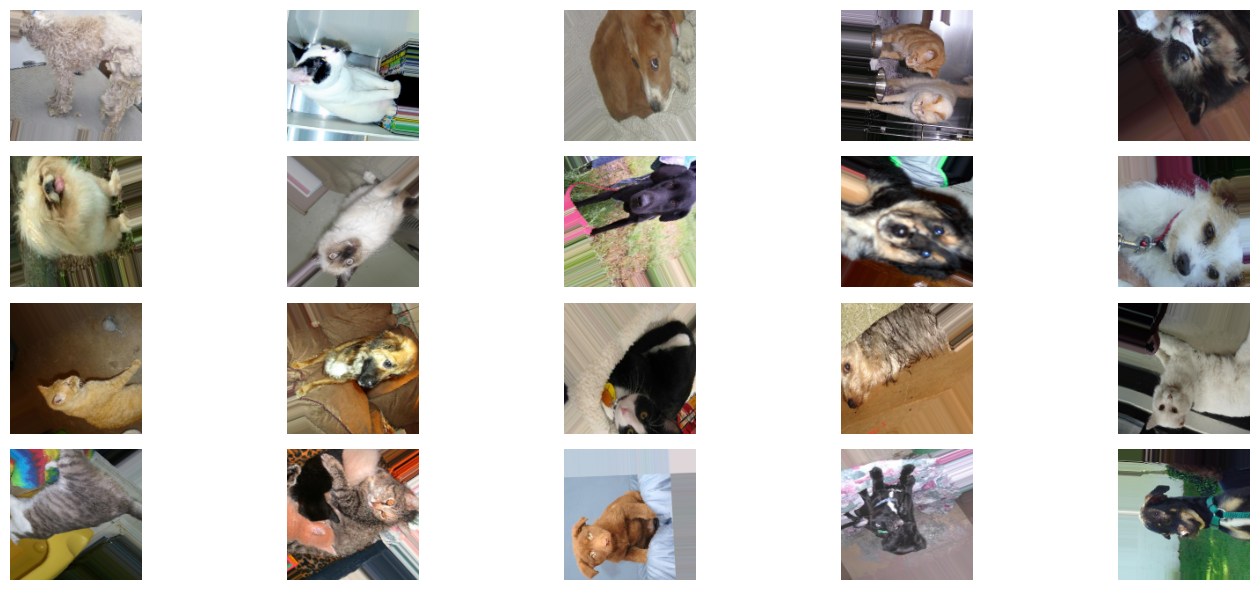

In [34]:
import matplotlib.pyplot as plt
import numpy as np


# Configure batch size and retrieve one batch of images
batch_size = 20

# Retrieve a single batch of images
batch = next(train_generator)[0].astype(np.float32)

# Plot the augmented images
plt.figure(figsize=(15, 6))
for i in range(batch_size):
    plt.subplot(4, 5, i + 1)
    plt.imshow(batch[i].reshape(150, 150, 3))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Train the new model
history_with_aug = model_for_aug.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_with_aug.history['accuracy']
val_acc=history_with_aug.history['val_accuracy']
loss=history_with_aug.history['loss']
val_loss=history_with_aug.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [36]:
import tensorflow_hub as hub

model_name = "mobilenet_v2_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Input size (224, 224)


In [46]:
print("Building model with", model_handle)
do_fine_tuning = False
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Dense(2,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [47]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [48]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator).history

Epoch 1/5
 983/1125 [=========================>....] - ETA: 53s - loss: 0.2611 - accuracy: 0.9771

C:\Users\jhpark\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 486s 427ms/step - loss: 0.2589 - accuracy: 0.9780 - val_loss: 0.2382 - val_accuracy: 0.9868
Epoch 2/5
1125/1125 [==============================] - 432s 384ms/step - loss: 0.2430 - accuracy: 0.9837 - val_loss: 0.2387 - val_accuracy: 0.9848
Epoch 3/5
1125/1125 [==============================] - 434s 386ms/step - loss: 0.2406 - accuracy: 0.9848 - val_loss: 0.2437 - val_accuracy: 0.9804
Epoch 4/5
1125/1125 [==============================] - 436s 388ms/step - loss: 0.2437 - accuracy: 0.9833 - val_loss: 0.2389 - val_accuracy: 0.9836
Epoch 5/5
1125/1125 [==============================] - 443s 394ms/step - loss: 0.2419 - accuracy: 0.9849 - val_loss: 0.2422 - val_accuracy: 0.9800
